# This code generates 
## Fig5. Maximum peak-to-peak amplitude of the EAP calculated in the different places of the field

In [1]:
# import necessary libraries
import numpy as np
import os.path
import sys
import matplotlib.pylab as plt
from eap import graph

ext = '.pdf'
%matplotlib inline

In [2]:
# simulate the cell (or use the data from previous simulation)
simulate_new = False # set False if you want to use previously saved simulated previously data

In [3]:
%cd ../../data/HallermannEtAl2012

/home/maria/maja/articles/lfp_phd/final code/data/HallermannEtAl2012


In [4]:
from calcs import simulate as sim

In [5]:
# get neuron params 
data_phys = sim.get_data('', simulate_new=simulate_new, run_original=True)
# exact parameters of the simulation are set in the simulate.py file

In [6]:
data_red = sim.get_data('', simulate_new=simulate_new, run_original=False)

In [7]:
# calculate local field potential
calc_lfp_new = True
field_size_type = 'detail' # this simulation takes a while because it calculates more points than the others

In [8]:
from calcs import calc_lfp 

In [9]:
# parameters for the field calculations
lfp_data_phys = calc_lfp.get_lfp_data(data_phys, calc_lfp_new=calc_lfp_new, field_size_type=field_size_type, run_original=True)

In [10]:
# remove it afterwards
data = sim.get_data('', simulate_new=simulate_new, run_original=True)
lfp_data_red = calc_lfp.get_lfp_data(data_red, calc_lfp_new=calc_lfp_new, field_size_type=field_size_type, run_original=False)

In [11]:
def calc_max_peak2peak(data):
    data_max = np.nanmax(data, axis=0)
    data_min = np.nanmin(data, axis=0)
    data_ampl = data_max - data_min
    return data_ampl

In [12]:
def calc_fraction(pt=0,no_segs = 5,line_range=[-200,300]):
    x_min, x_max = line_range
    
    if pt == x_min:
        return 0
    elif pt == x_max:
        return no_segs-1
    delta_x = np.diff(line_range)*1.0/no_segs
    n_x = int((pt-x_min)/delta_x)
    assert n_x < no_segs
    return n_x 

In [47]:
def plot_fig5b(lfp_data,run_original):
    # get params
    double_log = False
    
    v_ext = lfp_data['v_ext']
    x_range = lfp_data['x_range']
    y_range = lfp_data['y_range']

    amplitude = calc_max_peak2peak(v_ext)
    max_ampl = np.max(amplitude)

    # normalize
    ampl_norm = amplitude/max_ampl
    
    # calculates the distance voltage relationships
    ais_coord = [-8.10, -69.90]
    pts_y = np.array([0, ais_coord[1], 200, -200])
    pts_y_h = np.array([0, -60, 200, -200])
    pts_y_v = np.array([0])
    if run_original:
        color = 'r'
    else:
        color = 'g'

    subplots = [2,3]

    if (pts_y >= y_range[0]).all() and (pts_y <= y_range[1]).all():
        # plot all the horizontal plots
        idx = 1
        lin_range_x = np.linspace(x_range[0], x_range[1],np.size(ampl_norm,0))
        lin_range_y = np.linspace(y_range[0], y_range[1],np.size(ampl_norm,1))

        for pt_h in pts_y_h:
            frac = calc_fraction(pt=pt_h,no_segs=np.size(ampl_norm,1),
                               line_range=x_range)
            # plot it
            ax = plt.subplot(subplots[0],subplots[1], idx)
            idx+=1

            ampl_norm_0 = ampl_norm[frac,:]/np.max(ampl_norm[frac,:]) #max_frac
            ax.plot(lin_range_x, ampl_norm_0, color) 

            plt.title(pt_h)
            if double_log:
                ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim([0,700])
            ax.set_xlim([lin_range_x[0], lin_range_x[-1]])
            ax.set_ylim([0,1])
            ax.set_xlabel(u'space (µm)')
            ax.set_ylabel(u'voltage (normalized)')

        for pt_v in pts_y_v:
            frac = calc_fraction(pt=pt_v,no_segs=np.size(amplitude,1),
                               line_range=y_range)
            # normalize
            ax = plt.subplot(subplots[0],subplots[1], idx)
            idx+=1

            plt.plot(ampl_norm[:,frac],lin_range_y, color)
            if double_log:
                ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_xlim([0,1])
            plt.title(pt_v)
            ax.set_ylim([lin_range_y[0], lin_range_y[-1]])
            ax.set_ylabel(u'space (µm)')
            ax.set_xlabel(u'voltage (normalized)')       

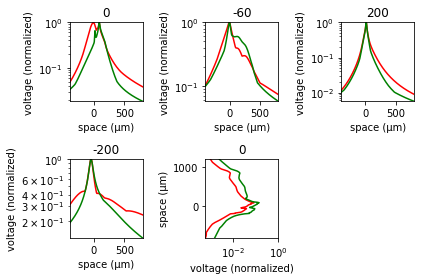

In [48]:
plot_fig5b(lfp_data_phys, run_original=True)
plot_fig5b(lfp_data_red, run_original= False)
plt.tight_layout()

ext = '.pdf'
plt.savefig('../../fig5B_'+field_size_type+ext)

In [15]:
def plot_fig5a(data, lfp_data, run_original, normalize = False):
    if run_original:
        color = 'r'
        title = 'physiological'
    else:
        color = 'g'
        title = 'reduced'
    v_ext = lfp_data['v_ext']
    x_range = lfp_data['x_range']
    y_range = lfp_data['y_range']
    seg_coords = data['seg_coords']
    ais_coord = [-8.10, -69.90]
    
    if normalize:
        vmax = 0.3
        ticks = [0, 0.1, 0.2, 0.3]
        str_ticks = ['0%', '10%', '20%', '>30%']
    elif run_original:
        vmax = 150
        ticks = [0, 50, 100, 150]
        str_ticks = [str(0), '50', '100', '>150']
    else:
        vmax = 100
        ticks = [0, 50, 100]
        str_ticks = [str(0), '50', '>100']   
    # plot the extracellular voltage
    from matplotlib import gridspec
    gs = gridspec.GridSpec(1, 2, width_ratios=(4, 0.3))#, 4,0.5))
    scalebar = 50
    v_ext_um = v_ext/10e2 # change to microvolts
    amplitude = calc_max_peak2peak(v_ext_um)

    if normalize:
        # normalize
        max_ampl = np.max(np.abs(amplitude))
        amplitude = amplitude/max_ampl

    ax = plt.subplot(gs[0,0])

    im = imshow_data(ax,amplitude,x_range=x_range,y_range=y_range,
                vmin=0,vmax=vmax,cmap=cm.YlOrRd,scalebar=scalebar,
                         xp_scbar=-100, yp_scbar=-110)
    autolim = False
    graph.plot_neuron(seg_coords, colors='0.4', autolim = autolim)
    ax.axis('off')
    ax.set_ylim(y_range)
    ax.set_xlim(x_range)
    plt.tight_layout()

    plt.hlines(0, x_range[0], x_range[1], color = color, linestyles='--')
    plt.vlines(0, y_range[0], y_range[1], color = color, linestyles='--')
    plt.hlines(ais_coord[1], x_range[0], x_range[1], color = color, linestyles='--')
    plt.hlines(200, x_range[0], x_range[1], color = color, linestyles='--')
    plt.hlines(-200, x_range[0], x_range[1], color = color, linestyles='--')

    scalebar = None
    plt.title(title)
    plt.tight_layout()

    axes = plt.subplot(gs[0,1])
    cbar = plt.colorbar(im, cax=axes, drawedges = False, ticks=ticks)
    cbar.ax.set_yticklabels(str_ticks)
    cbar.ax.set_ylabel(u'voltage (µV)')
    plt.tight_layout()

In [16]:
def plot_scalebar(ax, scalebar = 100, xp = 100, yp = -100):
# scalebar
    w, h = scalebar, scalebar
    plt.plot([xp, xp], [yp, yp+h], 'k-')
    plt.plot([xp, xp+h], [yp, yp], 'k-')
    plt.text(xp, yp+h/2., str(scalebar) +u" µm", ha='right', va='center',
             transform=ax.transData)
    plt.text(xp+h/2., yp, str(scalebar) + u" µm", ha='center', va='top',
             transform=ax.transData)

In [17]:
import matplotlib.cm as cm
# plot the imshow of the given field (2d array)
def imshow_data(ax, data, x_range, y_range, vmin=0, vmax=100, cmap=cm.YlOrRd,
               scalebar=100, xp_scbar=20, yp_scbar=-50, log=False, 
                autolim = True):    
    
    plt.sca(ax)
    if log:
        pl = plt.imshow(data, interpolation="nearest", 
           extent=(x_range[0], x_range[1], y_range[0], y_range[1]), 
           origin='lower', vmin=vmin, vmax=vmax, cmap=cmap,
            norm=colors.SymLogNorm(linthresh=0.01 * np.max(data),
                                                linscale=1.0,
                                                vmin=vmin, vmax=vmax))
    else:
        pl = plt.imshow(data, interpolation="nearest", 
           extent=(x_range[0], x_range[1], y_range[0], y_range[1]), 
           origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)     
    
    if scalebar != None:
        plot_scalebar(ax, scalebar=scalebar,xp=xp_scbar,yp=yp_scbar)

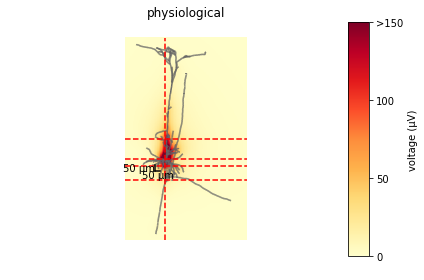

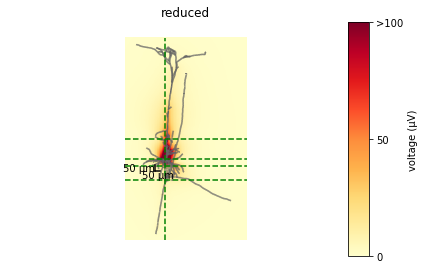

In [18]:
plt.figure()
plot_fig5a(data_phys, lfp_data_phys, run_original=True)
ext = '.pdf'
plt.savefig('../../fig5Aphys_'+field_size_type+ext)

plt.figure()
plot_fig5a(data_red, lfp_data_red, run_original=False)
ext = '.pdf'
plt.savefig('../../fig5Ared_'+field_size_type+ext)